In [3]:
# Import libraries:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine

# Display preferences
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

# Download dataset:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

houseprices_df = pd.read_sql_query('select * from houseprices',con=engine)

# No need for an open connection, because you're only doing a single query
engine.dispose()

houseprices_df_2 = houseprices_df.copy()

houseprices_df.head(10)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.000,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.000,14115,Pave,None,IR1,Lvl,AllPub,...,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.000,10084,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,...,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.000,6120,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.000,7420,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,1,2008,WD,Normal,118000


In [25]:
houseprices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 87 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1460 non-null   int64  
 1   mssubclass              1460 non-null   int64  
 2   mszoning                1460 non-null   object 
 3   lotfrontage             1201 non-null   float64
 4   lotarea                 1460 non-null   int64  
 5   street                  1460 non-null   object 
 6   alley                   91 non-null     object 
 7   lotshape                1460 non-null   object 
 8   landcontour             1460 non-null   object 
 9   utilities               1460 non-null   object 
 10  lotconfig               1460 non-null   object 
 11  landslope               1460 non-null   object 
 12  neighborhood            1460 non-null   object 
 13  condition1              1460 non-null   object 
 14  condition2              1460 non-null   

In [26]:
# Find how many missing values are in each column:
total = houseprices_df.isnull().sum().sort_values(ascending=False)
percent = (houseprices_df.isnull().sum()/houseprices_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
poolqc,1453,0.995
miscfeature,1406,0.963
alley,1369,0.938
fence,1179,0.808
fireplacequ,690,0.473
lotfrontage,259,0.177
garagefinish,81,0.055
garagequal,81,0.055
garageyrblt,81,0.055
garagetype,81,0.055


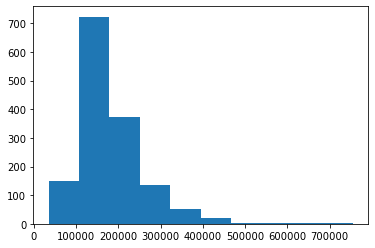

In [27]:
plt.hist(houseprices_df.saleprice)
plt.show()

In [4]:
# Seperate the dataset to numeric and non-numeric columns:
non_numeric_columns = houseprices_df.select_dtypes(['object']).columns
print(non_numeric_columns)
print('The number of non-numeric-columns is: {}'.format(len(non_numeric_columns)))

Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition'],
      dtype='object')
The number of non-numeric-columns is: 43


In [5]:
numeric_columns = houseprices_df.select_dtypes(['int64', 'float64']).columns
print(numeric_columns)
print('The number of numeric columns is: {}'. format(len(numeric_columns)))

Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch',
       'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice'],
      dtype='object')
The number of numeric columns is: 38


In [6]:
non_numeric_columns_df = houseprices_df.drop(houseprices_df.select_dtypes(['int64', 'float64']).columns, axis=1)
non_numeric_columns_df.head()

,mszoning,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,...,garagetype,garagefinish,garagequal,garagecond,paveddrive,poolqc,fence,miscfeature,saletype,salecondition
0,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
1,RL,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
2,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
3,RL,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,None,None,None,WD,Abnorml
4,RL,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal


In [8]:
numeric_columns_df = houseprices_df.drop(houseprices_df.select_dtypes(['object']).columns, axis=1)
numeric_columns_df.head()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,poolarea,miscval,mosold,yrsold,saleprice,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,street_Pave
0,1,60,65.000,8450,7,5,2003,2003,196.000,706,...,0,0,2,2008,208500,0,0,1,0,1
1,2,20,80.000,9600,6,8,1976,1976,0.000,978,...,0,0,5,2007,181500,0,0,1,0,1
2,3,60,68.000,11250,7,5,2001,2002,162.000,486,...,0,0,9,2008,223500,0,0,1,0,1
3,4,70,60.000,9550,7,5,1915,1970,0.000,216,...,0,0,2,2006,140000,0,0,1,0,1
4,5,60,84.000,14260,8,5,2000,2000,350.000,655,...,0,0,12,2008,250000,0,0,1,0,1


In [7]:
houseprices_df = pd.concat([houseprices_df,pd.get_dummies(houseprices_df.mszoning, prefix="mszoning", drop_first=True)], axis=1)
houseprices_df = pd.concat([houseprices_df,pd.get_dummies(houseprices_df.street, prefix="street", drop_first=True)], axis=1)
dummy_column_names = list(pd.get_dummies(houseprices_df.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(houseprices_df.street, prefix="street", drop_first=True).columns)

In [9]:
# EVALUATING PERFORMANCE:

# "Y" is the target veriable:
Y = houseprices_df['saleprice']

# "X" is the feature set:
X = houseprices_df[['overallqual', 'grlivarea', 'garagecars','garagearea', 'totalbsmtsf'] + dummy_column_names]

# Adding a constant to the model:
X = sm.add_constant(X)

# Fit an OLS model using statsmodels:
results = sm.OLS(Y, X).fit()

# Print the summery results:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     482.0
Date:                Mon, 10 Jan 2022   Prob (F-statistic):               0.00
Time:                        12:56:37   Log-Likelihood:                -17475.
No. Observations:                1460   AIC:                         3.497e+04
Df Residuals:                    1449   BIC:                         3.503e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.173e+05    1.8e+04     -6.502      

In [10]:
# Y is the target variable
Y = houseprices_df['saleprice']
# X is the feature set
X = houseprices_df[['overallqual', 'grlivarea', 'garagecars', 'totalbsmtsf', 'mszoning_RL']]

X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     956.8
Date:                Mon, 10 Jan 2022   Prob (F-statistic):               0.00
Time:                        12:57:31   Log-Likelihood:                -17481.
No. Observations:                1460   AIC:                         3.497e+04
Df Residuals:                    1454   BIC:                         3.501e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.083e+05   4804.236    -22.540      0.000   -1.18e+05   -9.89e+04
overallqual  2.396e+04   1060.549     22.588      0.000    2.19e+04     2.6e+04
grlivarea      45.4093      2.452     18.517      0.000      40.599      50.220
garagecars   1.763e+04   1731.766     10.183      0.000    1.42e+04     2.1e+04
totalbsmtsf    28.8729      2.862     10.088      0.000      23.259      34.487
mszoning_RL  1.596e+04   2558.589      6.238      0.000    1.09e+04     2.1e+04
==============================================================================
Omnibus:                      402.656   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            35429.680
Skew:                          -0.080   Prob(JB):                         0.00
Kurtosis:                      27.133   Cond. No.                     9.53e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.53e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

When looking at the comparison of the R-squared, the adjusted R-squared, the AIC, and the BIC, the only difference between the two models is that the second model's BIC is slightly lower (it is 35000, and in the first model it's 35020), which does indicate it's slightly better, but I'm not sure it's a significant enough of an indicator to prefer it over the first model.

In [11]:
houseprices_df['garagecars_totalbsmtsf'] = houseprices_df['garagecars'] * houseprices_df['totalbsmtsf']

# Y is the target variable
Y = houseprices_df['saleprice']
# X is the feature set
X = houseprices_df[['overallqual', 'grlivarea', 'garagecars', 'totalbsmtsf', 'mszoning_FV', 'mszoning_RL', 'garagecars_totalbsmtsf']]

X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     771.7
Date:                Mon, 10 Jan 2022   Prob (F-statistic):               0.00
Time:                        12:59:09   Log-Likelihood:                -17411.
No. Observations:                1460   AIC:                         3.484e+04
Df Residuals:                    1452   BIC:                         3.488e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    -3.7e+04   7672.783     -4.822      0.000    -5.2e+04   -2.19e+04
overallqual             2.147e+04   1043.698     20.571      0.000    1.94e+04    2.35e+04
grlivarea                 46.5505      2.347     19.837      0.000      41.947      51.154
garagecars             -1.735e+04   3398.445     -5.106      0.000    -2.4e+04   -1.07e+04
totalbsmtsf              -40.9939      6.627     -6.186      0.000     -53.994     -27.994
mszoning_FV             2.611e+04   5379.581      4.854      0.000    1.56e+04    3.67e+04
mszoning_RL             2.412e+04   2737.309      8.813      0.000    1.88e+04    2.95e+04
garagecars_totalbsmtsf    34.9336      2.999     11.649      0.000      29.051      40.816
==============================================================================
Omnibus:                      599.621   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            49995.605
Skew:                          -0.992   Prob(JB):                         0.00
Kurtosis:                      31.599   Cond. No.                     2.59e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.59e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

When we run this model in which we add the "garagecars" and "totalsbsmtsf" interaction veriable, it has a higher R-squared (0.788 vs 0.768), and higher adjusted R-squared (0.787 vs 0.767). What's more, it has a lower AIC -
(34840 vs 34970), and a lower BIC (34880 vs 35000). Also in this model, the coefficiants of "garagecars" and "totalsbsmtsf" become negative, which is a very strong indicator that the relationship between those two veriables is a much better predictor of the "saleprice" than each one of those veriables by itself.

In [12]:
# MAKING PREDICTIONS:

# "Y" is the target veriable:
Y = houseprices_df['saleprice']

# "X" is the feature set:
X = houseprices_df[['overallqual', 'grlivarea', 'garagecars','garagearea', 'totalbsmtsf'] + dummy_column_names]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [14]:
X_train.head()

,overallqual,grlivarea,garagecars,garagearea,totalbsmtsf,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,street_Pave
151,5,969,2,440,969,0,0,1,0,1
262,8,2574,3,868,1482,0,0,1,0,1
1037,8,2263,2,905,1055,0,0,1,0,1
1183,5,1130,2,720,1120,0,0,1,0,1
933,7,1500,2,570,1500,0,0,1,0,1


In [16]:
X_train = sm.add_constant(X_train)

# Fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# Print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     383.1
Date:                Mon, 10 Jan 2022   Prob (F-statistic):               0.00
Time:                        13:01:44   Log-Likelihood:                -13972.
No. Observations:                1168   AIC:                         2.797e+04
Df Residuals:                    1157   BIC:                         2.802e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.039e+05   2.06e+04     -5.037      

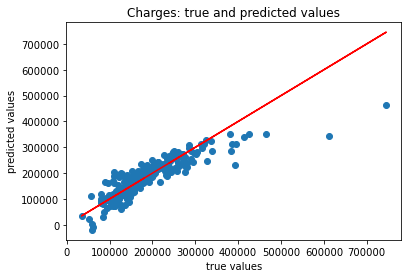

Mean absolute error of the prediction is: 25546.803828587937
Mean squared error of the prediction is: 1559083821.9730477
Root mean squared error of the prediction is: 39485.235493448024
Mean absolute percentage error of the prediction is: 15.551420347537178


In [17]:
# Add a constant to the model because it's best practice
# to do so every time!
X_test = sm.add_constant(X_test)

# You are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

In [18]:
houseprices_df['garagecars_totalbsmtsf'] = houseprices_df['garagecars'] * houseprices_df['totalbsmtsf']

# Y is the target variable
Y = houseprices_df['saleprice']
# X is the feature set
X = houseprices_df[['overallqual', 'grlivarea', 'garagecars', 'totalbsmtsf', 'mszoning_FV', 'mszoning_RL', 'garagecars_totalbsmtsf']]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in the training set is {}".format(X_train.shape[0]))
print("The number of observations in the test set is {}".format(X_test.shape[0]))

# Add a constant to the model because it's best practice
# to do so every time!
X_train = sm.add_constant(X_train)

# Fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# Print the summary results
print(results.summary())

The number of observations in the training set is 1168
The number of observations in the test set is 292
                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     607.9
Date:                Mon, 10 Jan 2022   Prob (F-statistic):               0.00
Time:                        13:07:15   Log-Likelihood:                -13926.
No. Observations:                1168   AIC:                         2.787e+04
Df Residuals:                    1160   BIC:                         2.791e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
--------------

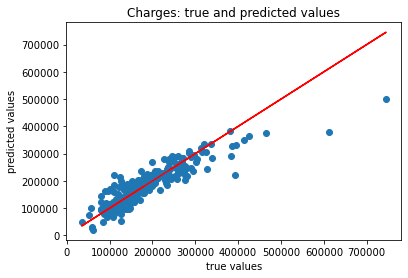

Mean absolute error of the prediction is: 24703.03792755079
Mean squared error of the prediction is: 1386967946.0116446
Root mean squared error of the prediction is: 37242.0185544721
Mean absolute percentage error of the prediction is: 15.013755258404252


In [20]:
# Add a constant to the model because it's best practice
# to do so every time!
X_test = sm.add_constant(X_test)

# You are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

In [29]:
# MANAGE OVERFITTING AND REGULARIZATION:

# `Y` is the target variable
Y = houseprices_df['saleprice']

numerical_cols = [col_name for col_name in houseprices_df.dtypes[houseprices_df.dtypes.values == 'int64'].index 
                    if col_name not in ["id", "saleprice"] ]

X = houseprices_df[numerical_cols]

X = pd.concat([X**i for i in range(1,21)], axis=1)

# `X` is the feature set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

# Fit an OLS model using scikit-learn
lrm = LinearRegression()
lrm.fit(X_train, y_train)


# You are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

The number of observations in training set is 1168
The number of observations in test set is 292
R-squared of the model in the training set is: 0.9488947670068492
-----Test set statistics-----
R-squared of the model in the test set is: -2.8610875567894872e+20
Mean absolute error of the prediction is: 136798401006634.03
Mean squared error of the prediction is: 1.9208495200603782e+30
Root mean squared error of the prediction is: 1385947156301559.0
Mean absolute percentage error of the prediction is: 47383724638.824005


In [22]:
from sklearn.linear_model import Ridge

# Fitting a ridge regression model. Here, `alpha` is the regularization
# parameter (usually called `lambda`). As `alpha` gets larger, parameter
# shrinkage grows more pronounced.
ridgeregr = Ridge(alpha=10**37) 
ridgeregr.fit(X_train, y_train)

# You are making predictions here
y_preds_train = ridgeregr.predict(X_train)
y_preds_test = ridgeregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.7081670276134313
-----Test set statistics-----
R-squared of the model on the test set is: 0.3556907496737214
Mean absolute error of the prediction is: 46568.26741741298
Mean squared error of the prediction is: 4325701642.100273
Root mean squared error of the prediction is: 65770.06645960055
Mean absolute percentage error of the prediction is: 27.54961672059381


In [23]:
from sklearn.linear_model import Lasso

lassoregr = Lasso(alpha=10**20.5) 
lassoregr.fit(X_train, y_train)

# You are making predictions here
y_preds_train = lassoregr.predict(X_train)
y_preds_test = lassoregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(lassoregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model on the training set is: 0.7592733802851299
-----Test set statistics-----
R-squared of the model on the test set is: 0.5302004163912533
Mean absolute error of the prediction is: 38129.53794620918
Mean squared error of the prediction is: 3154095380.8210363
Root mean squared error of the prediction is: 56161.33350287399
Mean absolute percentage error of the prediction is: 22.291343238152045


In [24]:
from sklearn.linear_model import ElasticNet

elasticregr = ElasticNet(alpha=10**21, l1_ratio=0.5) 
elasticregr.fit(X_train, y_train)

# You are making predictions here
y_preds_train = elasticregr.predict(X_train)
y_preds_test = elasticregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(elasticregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.7045694392934254
-----Test set statistics-----
R-squared of the model on the test set is: 0.41490931181520874
Mean absolute error of the prediction is: 42464.008417064295
Mean squared error of the prediction is: 3928125739.8941064
Root mean squared error of the prediction is: 62674.7615862566
Mean absolute percentage error of the prediction is: 23.991917920117505


In [30]:
# COMBINING EXTERNAL VERIABLES INTO MY MODEL:

interestrates_df = pd.read_csv('/Users/dannygoler/Dropbox/My Mac (Dannys-MacBook-Pro-2.local)/Desktop/Coding/2021/Data Science/CSVs/index_interest_rates_us.csv')
interestrates_df.head(10)

,Year,Month,Day,Federal Funds Target Rate,Federal Funds Upper Target,Federal Funds Lower Target,Effective Federal Funds Rate,Real GDP (Percent Change),Unemployment Rate,Inflation Rate
0,1954,7,1,NaN,NaN,NaN,0.800,4.600,5.800,NaN
1,1954,8,1,NaN,NaN,NaN,1.220,NaN,6.000,NaN
2,1954,9,1,NaN,NaN,NaN,1.060,NaN,6.100,NaN
3,1954,10,1,NaN,NaN,NaN,0.850,8.000,5.700,NaN
4,1954,11,1,NaN,NaN,NaN,0.830,NaN,5.300,NaN
5,1954,12,1,NaN,NaN,NaN,1.280,NaN,5.000,NaN
6,1955,1,1,NaN,NaN,NaN,1.390,11.900,4.900,NaN
7,1955,2,1,NaN,NaN,NaN,1.290,NaN,4.700,NaN
8,1955,3,1,NaN,NaN,NaN,1.350,NaN,4.600,NaN
9,1955,4,1,NaN,NaN,NaN,1.430,6.700,4.700,NaN


In [32]:
interestrates_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 904 entries, 0 to 903
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Year                          904 non-null    int64  
 1   Month                         904 non-null    int64  
 2   Day                           904 non-null    int64  
 3   Federal Funds Target Rate     462 non-null    float64
 4   Federal Funds Upper Target    103 non-null    float64
 5   Federal Funds Lower Target    103 non-null    float64
 6   Effective Federal Funds Rate  752 non-null    float64
 7   Real GDP (Percent Change)     250 non-null    float64
 8   Unemployment Rate             752 non-null    float64
 9   Inflation Rate                710 non-null    float64
dtypes: float64(7), int64(3)
memory usage: 70.8 KB


In [34]:
interestrates_df['clean_Unemployment_Rate'] = interestrates_df['Unemployment Rate'].dropna(inplace=True)
interestrates_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 904 entries, 0 to 903
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Year                          904 non-null    int64  
 1   Month                         904 non-null    int64  
 2   Day                           904 non-null    int64  
 3   Federal Funds Target Rate     462 non-null    float64
 4   Federal Funds Upper Target    103 non-null    float64
 5   Federal Funds Lower Target    103 non-null    float64
 6   Effective Federal Funds Rate  752 non-null    float64
 7   Real GDP (Percent Change)     250 non-null    float64
 8   Unemployment Rate             752 non-null    float64
 9   Inflation Rate                710 non-null    float64
 10  clean_Unemployment_Rate       0 non-null      object 
dtypes: float64(7), int64(3), object(1)
memory usage: 77.8+ KB


In [38]:
# houseprices_df = houseprices_df.concat(interestrates_df['clean_Unemployment_Rate'])
houseprices_df = houseprices_df.sort_values('yrsold')
houseprices_df.head(10)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,yrsold,saletype,salecondition,saleprice,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,street_Pave,garagecars_totalbsmtsf
781,782,60,RL,65.000,7153,Pave,None,Reg,Lvl,AllPub,...,2006,WD,Normal,175900,0,0,1,0,1,1522
282,282,20,FV,60.000,7200,Pave,Pave,Reg,Lvl,AllPub,...,2006,New,Partial,185000,1,0,0,0,1,2524
569,570,90,RL,NaN,7032,Pave,None,IR1,Lvl,AllPub,...,2006,WD,Normal,135960,0,0,1,0,1,1886
1219,1220,160,RM,21.000,1680,Pave,None,Reg,Lvl,AllPub,...,2006,WD,Abnorml,91500,0,0,0,1,1,0
571,572,20,RL,60.000,7332,Pave,None,Reg,Lvl,AllPub,...,2006,WD,Abnorml,120000,0,0,1,0,1,864
1220,1221,20,RL,66.000,7800,Pave,None,IR1,Lvl,AllPub,...,2006,WD,Abnorml,115000,0,0,1,0,1,912
577,578,80,RL,96.000,11777,Pave,None,IR1,Lvl,AllPub,...,2006,WD,Abnorml,164500,0,0,1,0,1,2328
1223,1224,20,RL,89.000,10680,Pave,None,Reg,Lvl,AllPub,...,2006,WD,Normal,137900,0,0,1,0,1,4272
271,271,60,FV,84.000,10728,Pave,None,Reg,Lvl,AllPub,...,2006,New,Partial,266000,1,0,0,0,1,3285
976,977,30,RL,51.000,5900,Pave,None,IR1,Bnk,AllPub,...,2006,WD,Normal,85500,0,0,1,0,1,0


In [39]:
def 
for colname, value in houseprices_df.iteritems():
    if colname == yrsold and value == value

id 781      782
282      282
569      570
1219    1220
571      572
        ... 
163      163
1322    1323
354      354
158      158
1284    1285
Name: id, Length: 1460, dtype: int64
mssubclass 781      60
282      20
569      90
1219    160
571      20
       ... 
163      20
1322     60
354      30
158      60
1284     50
Name: mssubclass, Length: 1460, dtype: int64
mszoning 781     RL
282     FV
569     RL
1219    RM
571     RL
        ..
163     RL
1322    RL
354     RM
158     RL
1284    RL
Name: mszoning, Length: 1460, dtype: object
lotfrontage 781     65.000
282     60.000
569        NaN
1219    21.000
571     60.000
         ...  
163     95.000
1322   107.000
354     60.000
158     92.000
1284    50.000
Name: lotfrontage, Length: 1460, dtype: float64
lotarea 781      7153
282      7200
569      7032
1219     1680
571      7332
        ...  
163     12182
1322    10186
354      8520
158     12003
1284     9638
Name: lotarea, Length: 1460, dtype: int64
street 781     Pave
282   